# Iris Flower and Publish Model

In this notebook we will:
1. Load the Iris Flower dataset into random split(train/test) DataFrames using a Feature View.
2. Train a KNN model using sklearn.
3. Evalute model performance on the test set.
4. Register the model with Hopsworks Model Registry.

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import os
import hopsworks
from dotenv import load_dotenv
load_dotenv()

api_key = str(os.getenv("HOPSWORKS_API_KEY"))

c:\Users\amuly\AppData\Local\pypoetry\Cache\virtualenvs\hopsworks-tutorial-VpIe_r9K-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's first get a feature_view for the Iris dataset, or create on if does not already exist. if you are arunning this notebook for the first time, it will create the feature view, which contains all the columns from the **feature gruop**

In [2]:
project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()

2025-02-14 18:40:01,820 INFO: Initializing external client
2025-02-14 18:40:01,820 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-14 18:40:04,703 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1212597


In [3]:
try:
    feature_view = fs.get_feature_view(name="iris", version=1)

except:
    iris_fg = fs.get_feature_group(name="iris", version=1)
    query = iris_fg.select_all()
    feature_view = fs.create_feature_view(name="iris",
                                          version=1,
                                          description="Read from Iris flower dataset",
                                          labels=["variety"],
                                          query=query)

We will read our features and labels split into a **train_set** and a **test_set**. You split your data into a train_set and test_set, because you want to train your model on train_set, and then evaluate its performance on data that was not seen during training, the test_set.

In [4]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.84s) 


In [5]:
y_train

,variety
3,Versicolor
4,Virginica
5,Setosa
8,Versicolor
9,Versicolor
...,...
146,Setosa
147,Versicolor
148,Setosa
149,Versicolor


Now, we can fit a model to our features and labels from our training set(**X_train**, **y_train**).

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)

y_test = label_encoder.transform(y_test)

In [7]:
model = KNeighborsClassifier(n_neighbors=2)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [8]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 0, 2, 2, 0, 2, 1, 0, 1, 2, 2,
       1, 0, 2, 0, 2, 2, 1, 2, 1])

In [9]:
from sklearn.metrics import classification_report

metrics = classification_report(y_test, y_pred, output_dict=True)
print(metrics)

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9.0}, '1': {'precision': 1.0, 'recall': 0.8, 'f1-score': 0.8888888888888888, 'support': 10.0}, '2': {'precision': 0.8571428571428571, 'recall': 1.0, 'f1-score': 0.9230769230769231, 'support': 12.0}, 'accuracy': 0.9354838709677419, 'macro avg': {'precision': 0.9523809523809524, 'recall': 0.9333333333333332, 'f1-score': 0.9373219373219372, 'support': 31.0}, 'weighted avg': {'precision': 0.9447004608294931, 'recall': 0.9354838709677419, 'f1-score': 0.9343810311552248, 'support': 31.0}}


In [10]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_test, y_pred)

print(results)

[[ 9  0  0]
 [ 0  8  2]
 [ 0  0 12]]


Notice in the confusion matrix results that we have 1 or 2 incorrect predictions.
We have only 30 flowers in our test set - **y_test**.
Our model predicted 1 or 2 flowers were of type "Virginica", but the flowers were, in fact, "Versicolor".

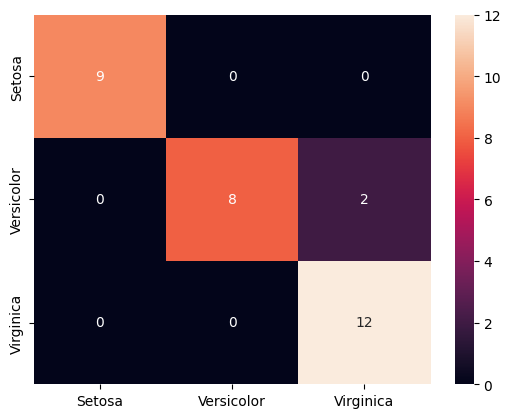

In [11]:
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(
    results,
    index=label_encoder.classes_,
    columns=label_encoder.classes_
)

cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()
plt.savefig("../assets/confusion_matrix.png")
plt.show()

## Register the model with Hopsworks Model Registry


In [13]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import hopsworks
import shutil

mr = project.get_model_registry()

# The 'iris_model' directory will be saved to the model registry
model_dir = "../iris_model"

if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

joblib.dump(model, model_dir + "/iris_model.pkl")
joblib.dump(label_encoder, model_dir + "/label_encoder.pkl")
shutil.copyfile('../assets/confusion_matrix.png',
                model_dir + '/confusion_matrix.png')

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

iris_model = mr.python.create_model(
    version=3,
    name="iris",
    metrics={"accuracy": metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example,
    description="Iris Flower Predictor")

iris_model.save(model_dir)

Uploading: 100.000%|██████████| 15086/15086 elapsed<00:02 remaining<00:005,  1.10s/it]
Uploading: 100.000%|██████████| 11702/11702 elapsed<00:02 remaining<00:005,  1.10s/it]
Uploading: 100.000%|██████████| 564/564 elapsed<00:02 remaining<00:0000:05,  1.10s/it]
Uploading: 100.000%|██████████| 20/20 elapsed<00:02 remaining<00:0009<00:21,  5.37s/it]
Uploading: 100.000%|██████████| 484/484 elapsed<00:03 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:22<00:00,  3.76s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1212597/models/iris/3


Model(name: 'iris', version: 3)